In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from dateutil.relativedelta import relativedelta

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,roc_auc_score,log_loss,roc_curve,accuracy_score,f1_score,average_precision_score
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier
  
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)
pd.set_option('display.width',200)

### import data

In [2]:
df= pd.read_csv("train.csv")
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [9]:
df.shape

(233154, 41)

In [4]:
print(df['loan_default'].value_counts()/len(df))

0    0.782929
1    0.217071
Name: loan_default, dtype: float64


### check duplicate

In [13]:
#check if there is duplicate records
df.drop_duplicates().shape

(233154, 41)

In [17]:
#check if there is more than 1 record per client
len(df['UniqueID'].unique())

233154

In [18]:
#what is pincode
len(df['Current_pincode_ID'].unique())

6698

### missing values

In [19]:
#check missing values
df.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

### create age column

In [6]:
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'],format = '%d-%m-%y')
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'],format = '%d-%m-%y')


In [7]:
df['Age'] = df.apply(lambda x: relativedelta(x['DisbursalDate'],x['Date.of.Birth']).years, axis=1)

#some date of birth are read as 20XX, if DOB is in future, add 100 to age
df.loc[df['Age']<0,'Age'] = df['Age'] + 100

df[['Date.of.Birth','DisbursalDate','Age']].head()

,Date.of.Birth,DisbursalDate,Age
0,1984-01-01,2018-08-03,34
1,1985-07-31,2018-09-26,33
2,1985-08-24,2018-08-01,32
3,1993-12-30,2018-10-26,24
4,1977-12-09,2018-09-26,40


change credit history and average account age format

In [3]:
df['CreditAge'] = df['CREDIT.HISTORY.LENGTH'].str.split("yrs",expand=True)[0].astype(int) * 12 + df['CREDIT.HISTORY.LENGTH'].str.split("yrs",expand=True)[1].str.split("mon",expand=True)[0].astype(int)
df['LoanAge'] = df['AVERAGE.ACCT.AGE'].str.split("yrs",expand=True)[0].astype(int) * 12 + df['AVERAGE.ACCT.AGE'].str.split("yrs",expand=True)[1].str.split("mon",expand=True)[0].astype(int)

df[['AVERAGE.ACCT.AGE','LoanAge']].head()

,AVERAGE.ACCT.AGE,LoanAge
0,0yrs 0mon,0
1,1yrs 11mon,23
2,0yrs 0mon,0
3,0yrs 8mon,8
4,0yrs 0mon,0


### impute employment type

In [65]:
df['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Name: Employment.Type, dtype: int64

In [8]:
df['Employment.Type'] = df['Employment.Type'].fillna('missing')

In [67]:
df['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
missing            7661
Name: Employment.Type, dtype: int64

### check data

In [28]:
numerical = ['disbursed_amount', 'asset_cost', 'ltv','PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 
             'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 
             'SEC.INSTAL.AMT','NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
             'NO.OF_INQUIRIES', 'Age', 'CreditAge', 'LoanAge']
categorical = [ 'manufacturer_id', 'Employment.Type','State_ID',
               'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag'
               , 'Passport_flag','PERFORM_CNS.SCORE.DESCRIPTION']

branch_id
251    34.391259
254    32.430842
97     31.362468
36     29.676178
78     29.147571
153    28.612717
117    28.315412
146    28.255208
105    28.246753
65     28.184668
16     28.069904
35     27.849928
10     27.684848
158    27.536232
74     27.181755
147    27.139423
120    26.555819
69     26.543210
260    26.344086
14     25.673941
85     25.639659
248    24.768645
217    24.590164
76     23.976608
64     23.876063
101    23.369565
18     23.231320
259    22.832370
13     22.779273
249    22.727273
61     22.645740
111    22.471910
165    22.233105
5      22.206552
261    22.159091
202    22.011006
79     22.004102
136    21.971148
159    21.908257
255    21.636364
250    21.607022
43     21.404110
29     21.229773
62     21.128799
11     20.905459
138    20.795037
72     20.788253
258    20.588235
7      20.360025
73     20.357634
130    20.112254
84     19.871795
257    19.824841
68     19.792567
48     19.703704
20     19.521553
207    19.448476
67     19.403249
121 

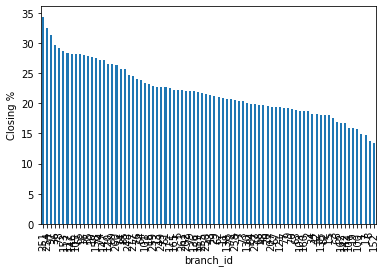

supplier_id
15045    100.0
24109    100.0
23685    100.0
23741    100.0
18513    100.0
         ...  
21702      0.0
15383      0.0
22954      0.0
21703      0.0
23336      0.0
Name: loan_default, Length: 2953, dtype: float64


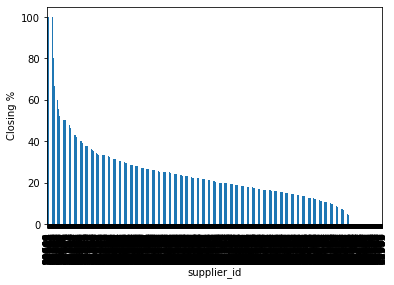

manufacturer_id
153    33.333333
48     27.253142
45     22.849928
120    22.074964
49     21.878669
67     21.746362
51     20.794736
86     20.459401
145    20.051414
152     0.000000
156     0.000000
Name: loan_default, dtype: float64


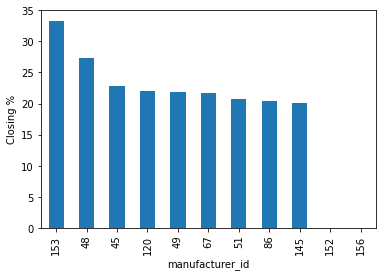

Current_pincode_ID
3070    100.0
4522    100.0
4682    100.0
4567    100.0
4556    100.0
        ...  
4889      0.0
4888      0.0
4887      0.0
4886      0.0
7345      0.0
Name: loan_default, Length: 6698, dtype: float64


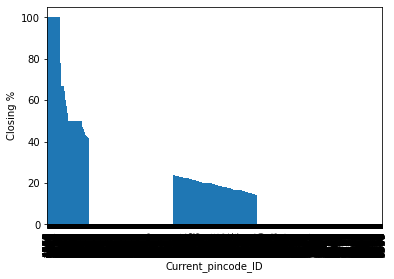

Employment.Type
Self employed    22.765699
missing          21.459340
Salaried         20.345807
Name: loan_default, dtype: float64


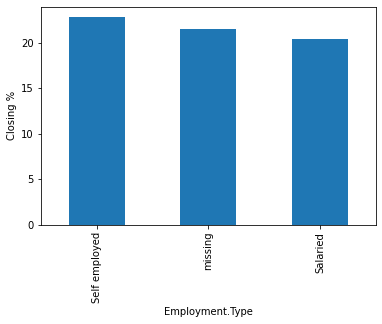

State_ID
13    30.658689
14    27.586573
2     27.139423
12    26.555819
17    24.580306
8     22.948510
18    22.006652
9     21.795032
15    21.152704
4     20.784489
6     20.564095
11    20.428508
7     20.173887
5     19.878157
21    19.871795
3     18.619050
16    18.361266
19    18.067633
1     17.714861
10    17.558946
20    17.297297
22    11.842105
Name: loan_default, dtype: float64


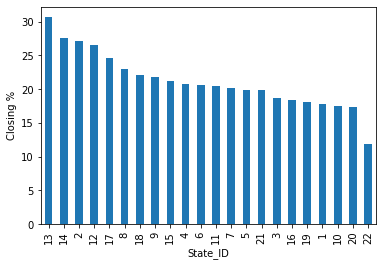

Employee_code_ID
3795    100.0
3771    100.0
350     100.0
3685    100.0
3101    100.0
        ...  
3534      0.0
3530      0.0
2918      0.0
148       0.0
3700      0.0
Name: loan_default, Length: 3270, dtype: float64


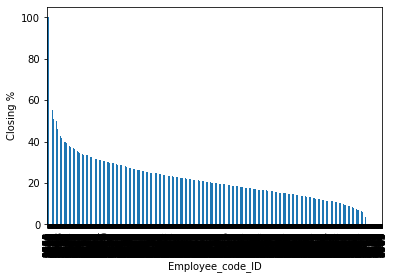

MobileNo_Avl_Flag
1    21.707112
Name: loan_default, dtype: float64


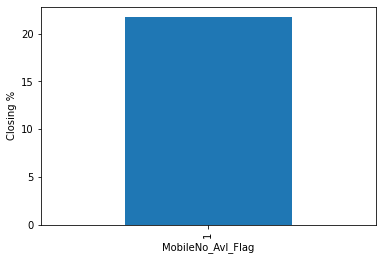

Aadhar_flag
0    25.640612
1    20.959658
Name: loan_default, dtype: float64


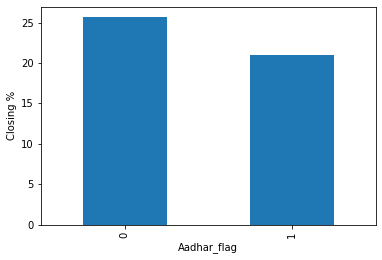

PAN_flag
1    22.002157
0    21.682991
Name: loan_default, dtype: float64


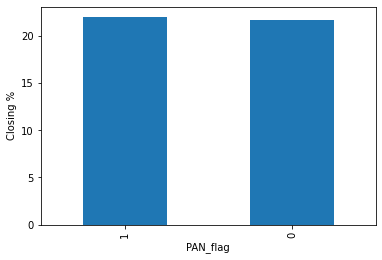

VoterID_flag
1    26.087471
0    20.964587
Name: loan_default, dtype: float64


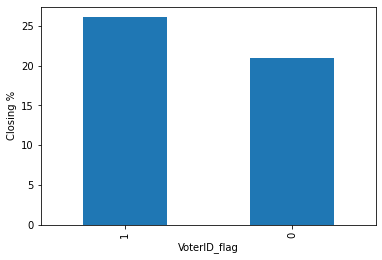

Driving_flag
0    21.744132
1    20.151319
Name: loan_default, dtype: float64


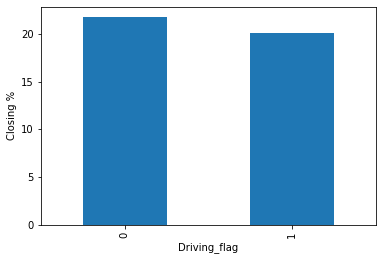

Passport_flag
0    21.721583
1    14.919355
Name: loan_default, dtype: float64


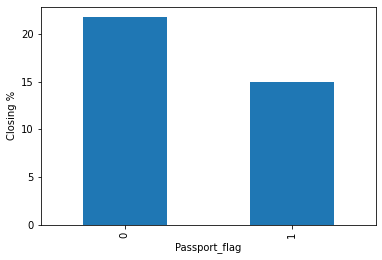

PERFORM_CNS.SCORE.DESCRIPTION
M-Very High Risk                                           30.458067
L-Very High Risk                                           28.042328
K-High Risk                                                27.812009
I-Medium Risk                                              27.262912
Not Scored: Sufficient History Not Available               25.577689
J-High Risk                                                25.240128
H-Medium Risk                                              24.186725
No Bureau History Available                                23.131253
Not Scored: Only a Guarantor                               21.311475
Not Scored: Not Enough Info available on the customer      20.969499
G-Low Risk                                                 19.709127
Not Scored: No Updates available in last 36 months         19.035202
F-Low Risk                                                 18.621096
Not Scored: No Activity seen on the customer (Inactive)    18.370884
C-Ve

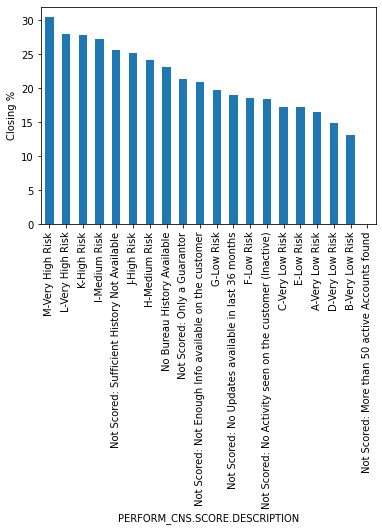

In [42]:
#check categorical variables
for i in categorical:
    #Group the data
    grouped = df.groupby(i)['loan_default'].mean().sort_values(ascending=False) * 100
    #plot it 
    print(grouped)
    plt.figure()
    ax = grouped.plot.bar()
    ax.set_ylabel('Closing %')
    plt.show()

Employment.Type
Self employed    0.227657
missing          0.214593
Salaried         0.203458
Name: loan_default, dtype: float64


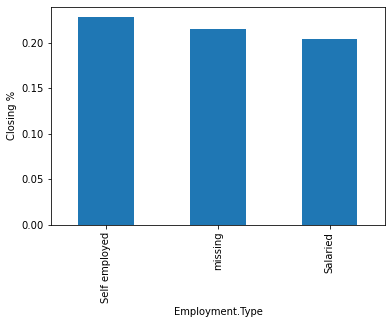

In [8]:
grouped = df.groupby('Employment.Type')['loan_default'].mean().sort_values(ascending=False)

print(grouped)
plt.figure()
ax = grouped.plot.bar()
ax.set_ylabel('Closing %')
plt.show()

In [14]:
df[categorical + numerical].describe()

,manufacturer_id,State_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Age,CreditAge,LoanAge
count,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,69.028054,7.262243,1.0,0.84032,0.075577,0.144943,0.023242,0.002127,54356.993528,7.586507e+04,74.746530,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,34.024452,16.252404,8.915764
std,22.141304,4.482230,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,12971.314171,1.894478e+04,11.456636,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,9.993986,28.581255,15.106416
min,45.000000,1.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,13320.000000,3.700000e+04,10.030000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000
25%,48.000000,4.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,47145.000000,6.571700e+04,68.880000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000
50%,86.000000,6.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,53803.000000,7.094600e+04,76.800000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000
75%,86.000000,10.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,60413.000000,7.920175e+04,83.670000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,41.000000,24.000000,13.000000
max,156.000000,22.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,990572.000000,1.628992e+06,95.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,70.000000,468.000000,369.000000


### drop irrelevent columns

In [7]:
#remove not relevent columns
df = df.drop(columns=['UniqueID','branch_id','supplier_id','Employee_code_ID','Current_pincode_ID','Date.of.Birth','DisbursalDate','MobileNo_Avl_Flag'])

In [49]:
df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'CreditAge', 'LoanAge', 'Age', 'no_of_accts', 'active_accts',
       'overdue_accts', 'current_balance', 'psdisbursed_amt', 'install_amt', 'state_rate', 'Employment.Type_Salaried', 'Employment.Type_Self employed', 'Employment.Type_missing', 'manufacturer_120',
       'manufacturer_45', 'manufacturer_48', 'manufacturer_49', 'manufacturer_51', 'manufacturer_86', 'manufacturer_other'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

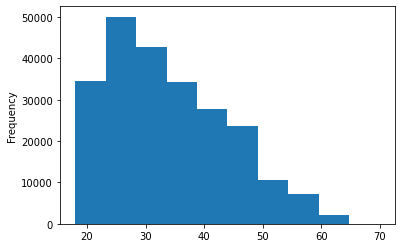

In [61]:
df['Age'].plot.hist()

### check multicollinearity

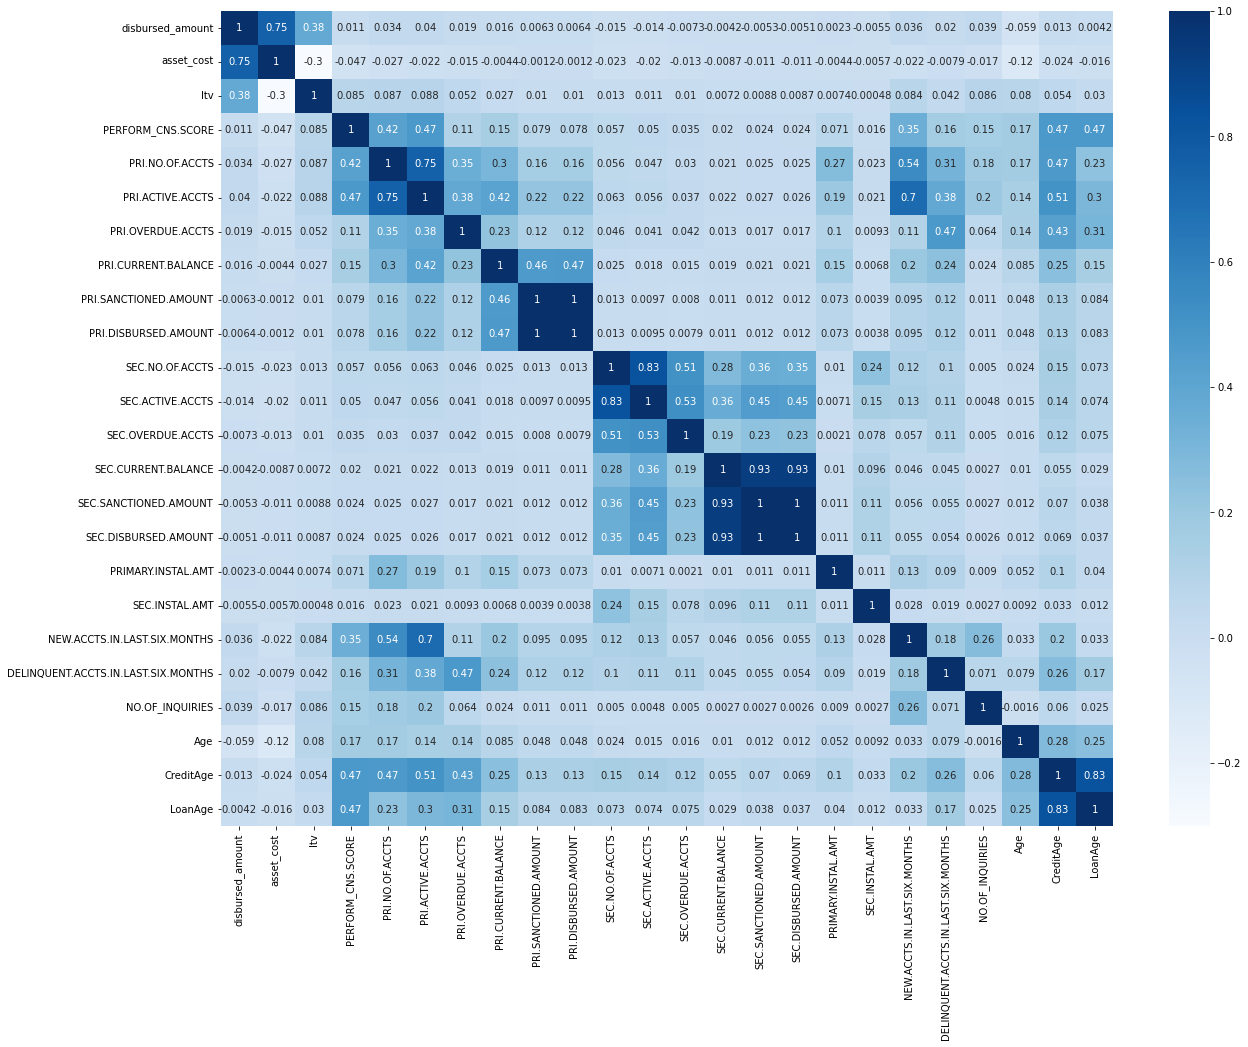

In [66]:
plt.figure(figsize=(20,15))
sns.heatmap(df[numerical].corr(),annot=True,cmap='Blues')
plt.show()

In [17]:
df[numerical2].shape

(233154, 29)

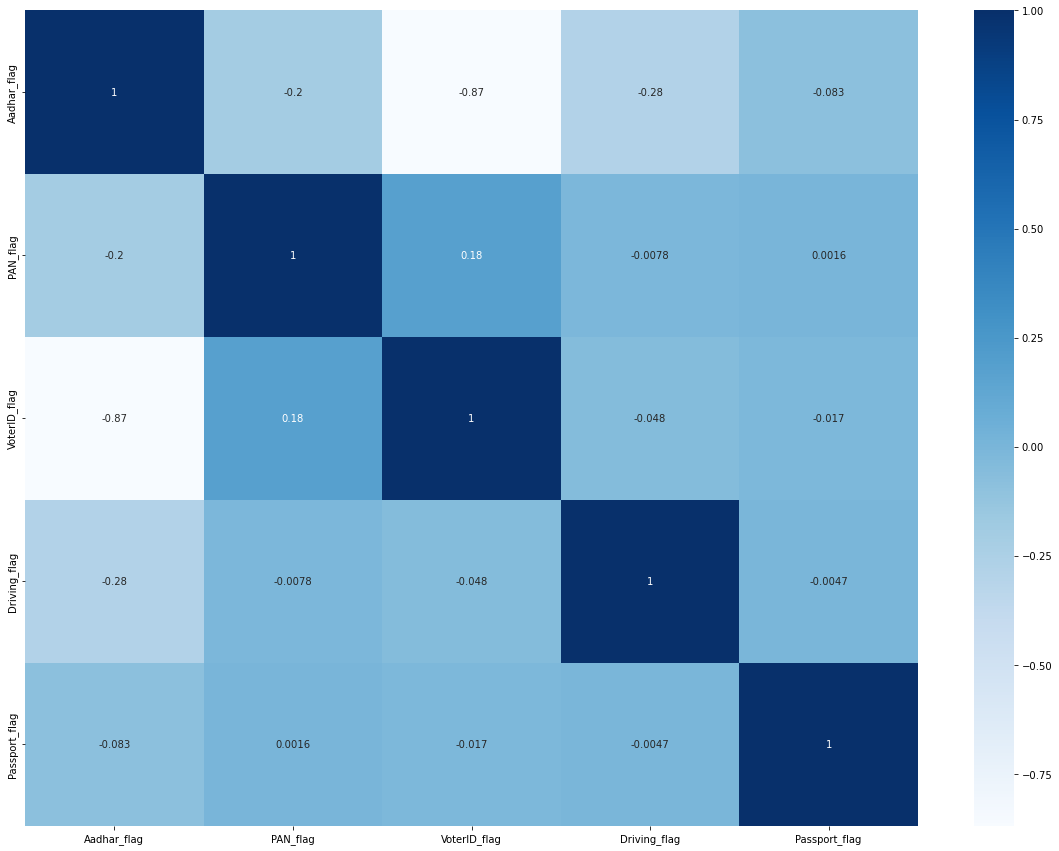

In [32]:
plt.figure(figsize=(20,15))
sns.heatmap(df[['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag']].corr(),annot=True,cmap='Blues')
plt.show()

In [26]:
df = df.drop(columns=['SEC.SANCTIONED.AMOUNT','PRI.SANCTIONED.AMOUNT'])

In [39]:
df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth', 'Employment.Type', 'DisbursalDate', 'State_ID',
       'Employee_code_ID', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'CreditAge', 'LoanAge', 'Age',
       'no_of_accts', 'active_accts', 'overdue_accts', 'current_balance', 'psdisbursed_amt', 'install_amt'],
      dtype='object')

In [72]:
numerical = ['disbursed_amount', 'ltv','PERFORM_CNS.SCORE',  'active_accts', 
             'overdue_accts', 'current_balance', 'psdisbursed_amt', 'install_amt','NEW.ACCTS.IN.LAST.SIX.MONTHS',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES', 'Age',  'LoanAge']
numerical2 = numerical+[ 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag']


X = df[numerical2]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns



In [73]:
vif

,VIF,feature
0,20.256840,disbursed_amount
1,29.557539,ltv
2,2.822981,PERFORM_CNS.SCORE
3,4.392411,active_accts
4,1.687642,overdue_accts
5,1.579283,current_balance
6,1.305990,psdisbursed_amt
7,1.056822,install_amt
8,2.788035,NEW.ACCTS.IN.LAST.SIX.MONTHS
9,1.494198,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS


In [8]:
#SANCTIONED.AMOUNT is same as DISBURSTED.AMOUNT
df = df.drop(columns=['PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT'])

In [37]:
#combining features
df['no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df['active_accts'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']
df['overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df['current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df['psdisbursed_amt'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df['install_amt'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

df = df.drop(columns=[ 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE','PRI.DISBURSED.AMOUNT', 
             'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 
             'SEC.INSTAL.AMT',])

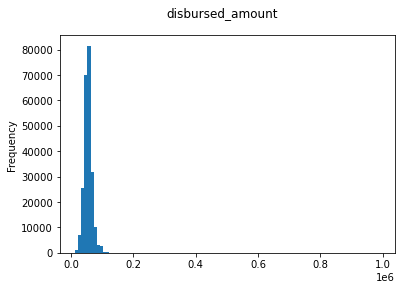

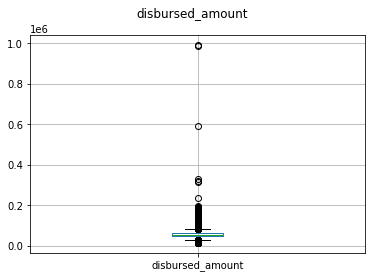

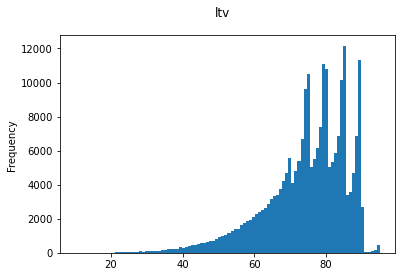

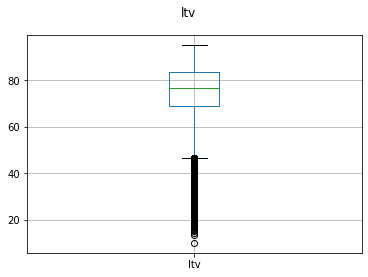

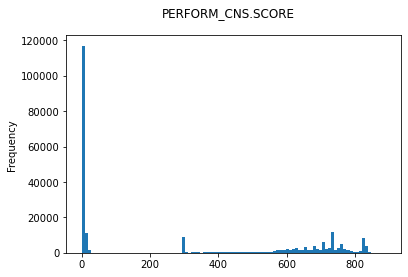

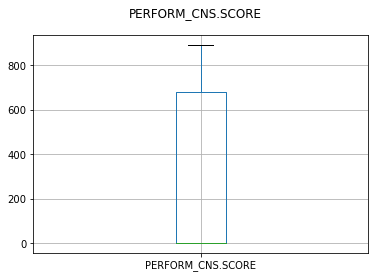

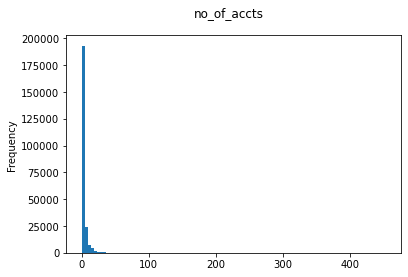

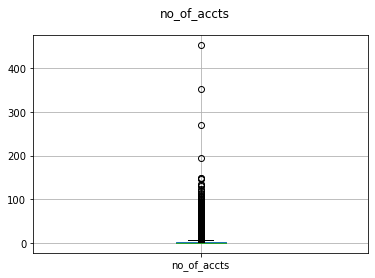

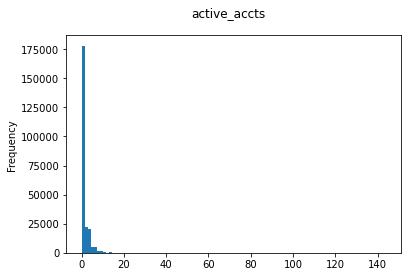

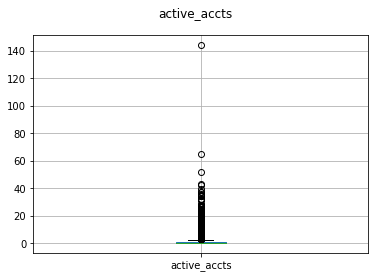

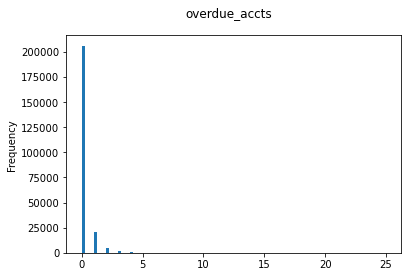

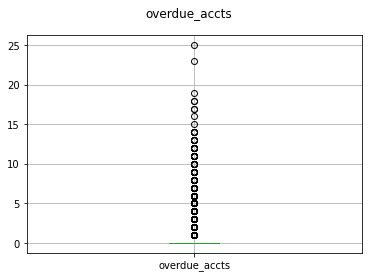

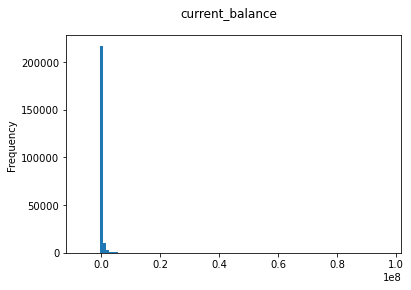

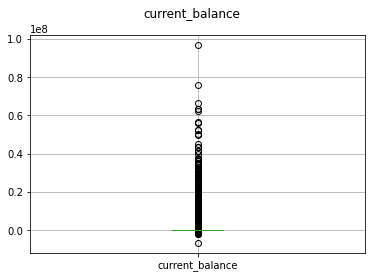

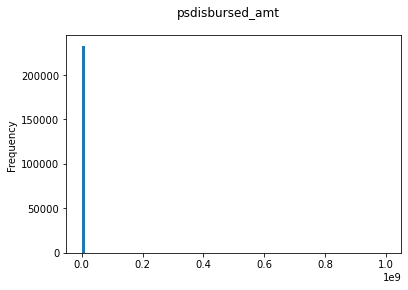

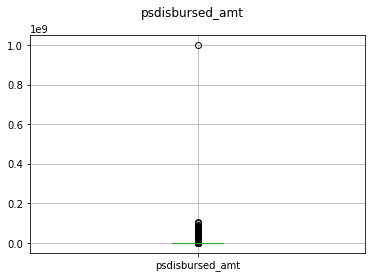

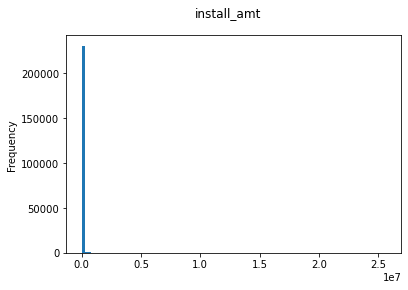

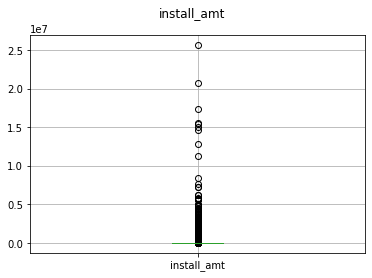

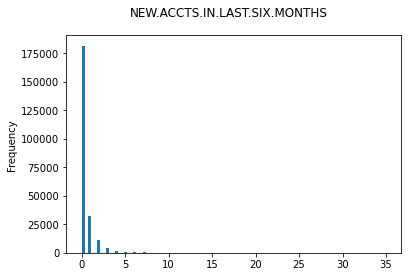

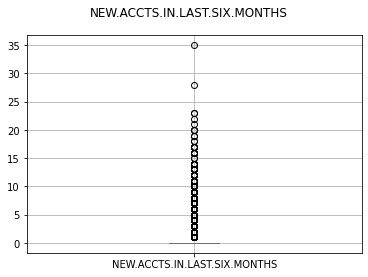

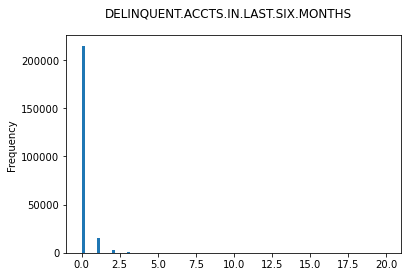

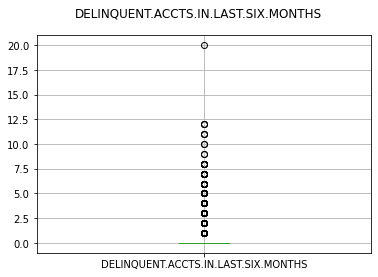

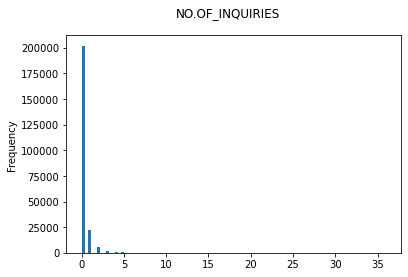

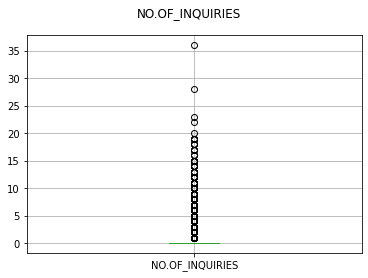

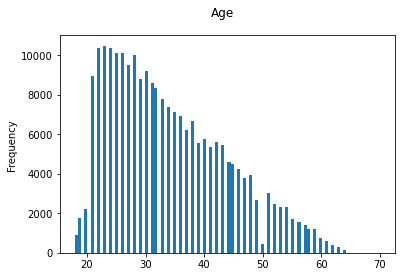

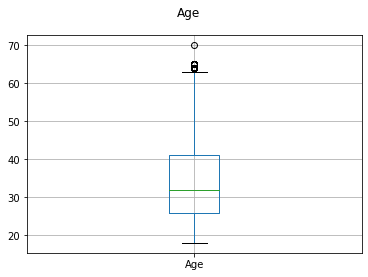

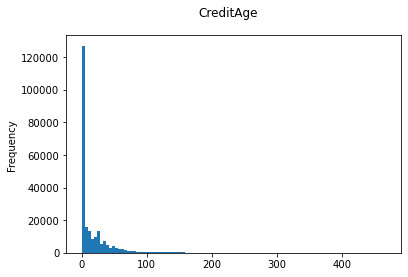

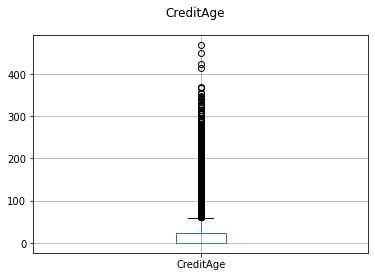

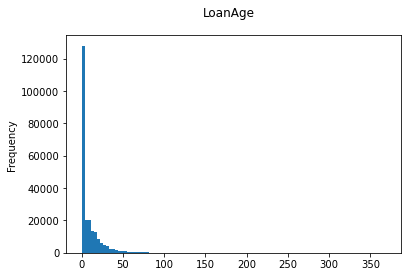

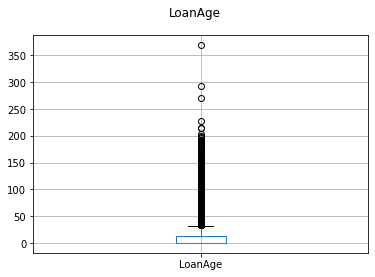

In [43]:

for col in numerical:
    
    df[col].plot.hist(bins = 100)
    plt.suptitle(col)
    plt.show()
    
    df.boxplot(col)
    plt.suptitle(col)
    plt.show()

In [117]:
for col in categorical:
    if(col not in df.columns):
        print(col + ' not in columns')
    else:
        print(df.groupby(col).agg({'loan_default':['mean','count']}).sort_values([('loan_default', 'count')],ascending=False))

branch_id not in columns
supplier_id not in columns
                loan_default        
                        mean   count
manufacturer_id                     
86                  0.204594  109534
45                  0.228499   56626
51                  0.207947   27204
48                  0.272531   16710
49                  0.218787   10220
120                 0.220750    9658
67                  0.217464    2405
145                 0.200514     778
153                 0.333333      12
152                 0.000000       6
156                 0.000000       1
Current_pincode_ID not in columns
                loan_default        
                        mean   count
Employment.Type                     
Self employed       0.227657  127635
Salaried            0.203458   97858
missing             0.214593    7661
         loan_default       
                 mean  count
State_ID                    
4            0.207845  44870
3            0.186191  34078
6            0.205641  33505


In [44]:
X1 = df
y1 = df['loan_default']
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X1, y1, test_size=0.20, random_state=42)
X_train1.groupby('State_ID').agg({'loan_default':['mean','count']}).sort_values([('loan_default', 'count')],ascending=False)


loan_default       
                 mean  count
State_ID                    
4            0.206786  35897
3            0.185881  27297
6            0.206568  26795
13           0.307198  14323
9            0.218234  12789
8            0.227077  11375
5            0.198228   8127
14           0.277420   7613
1            0.174508   7163
7            0.202650   5433
11           0.207070   5375
18           0.219939   4233
15           0.211139   4040
2            0.271720   3338
12           0.268976   3320
17           0.244873   3218
10           0.172438   2888
16           0.181391   2128
19           0.173031    838
20           0.183673    147
21           0.233871    124
22           0.112903     62

In [46]:
manufacturer_id_keep_set = [86,45,51,48,49,120]
df['manufacturer'] = [x if x in manufacturer_id_keep_set else 'other' for x in df['manufacturer_id']]
df['manufacturer'] = df['manufacturer'].astype(str)

In [73]:
df[['manufacturer','manufacturer_id']][df.manufacturer_id == 67].head(5)

,manufacturer,manufacturer_id
923,other,67
968,other,67
1151,other,67
1212,other,67
1723,other,67


In [70]:
df[['manufacturer']].dtypes

manufacturer    object
dtype: object

In [47]:
onehot_cols = ['Employment.Type', 'manufacturer'] 

#import pandas as pd
df = pd.get_dummies(df, columns = onehot_cols)

In [48]:
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,CreditAge,LoanAge,Age,no_of_accts,active_accts,overdue_accts,current_balance,psdisbursed_amt,install_amt,state_rate,Employment.Type_Salaried,Employment.Type_Self employed,Employment.Type_missing,manufacturer_120,manufacturer_45,manufacturer_48,manufacturer_49,manufacturer_51,manufacturer_86,manufacturer_other
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,2018-08-03,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0yrs 0mon,0yrs 0mon,0,0,0,0,34,0,0,0,0,0,0,0.206568,1,0,0,0,1,0,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,0,1,1yrs 11mon,1yrs 11mon,0,1,23,23,33,1,1,1,27600,50200,1991,0.206568,0,1,0,0,1,0,0,0,0,0
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,2018-08-01,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0yrs 0mon,0yrs 0mon,0,0,0,0,32,0,0,0,0,0,0,0.206568,0,1,0,0,1,0,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,0,0,0yrs 8mon,1yrs 3mon,1,1,15,8,24,3,0,0,0,0,31,0.206568,0,1,0,0,1,0,0,0,0,0
4,539055,52378,60300,88.39,67,22807,45,1495,1977-12-09,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0yrs 0mon,0yrs 0mon,1,1,0,0,40,0,0,0,0,0,0,0.206568,0,1,0,0,1,0,0,0,0,0


In [45]:
df["state_rate"] = ""
mapping = {4:0.206786,
3:0.185881,
6:0.206568,
13:0.307198,
9:0.218234,
8:0.227077,
5:0.198228,
14:0.27742,
1:0.174508,
7:0.20265,
11:0.20707,
18:0.219939,
15:0.211139,
2:0.27172,
12:0.268976,
17:0.244873,
10:0.172438,
16:0.181391,
19:0.173031,
20:0.183673,
21:0.233871,
22:0.112903}
for i in mapping:
        df["state_rate"] = np.where(df["State_ID"] == i, mapping[i], df["state_rate"])
        
df['state_rate'] = df['state_rate'].astype(float)

In [18]:
df[['State_ID',"state_rate"]].head(5)

,State_ID,state_rate
0,6,0.195917
1,6,0.195917
2,6,0.195917
3,6,0.195917
4,6,0.195917


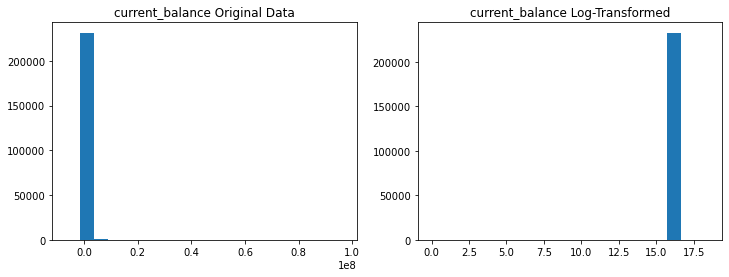

<Figure size 720x1440 with 0 Axes>

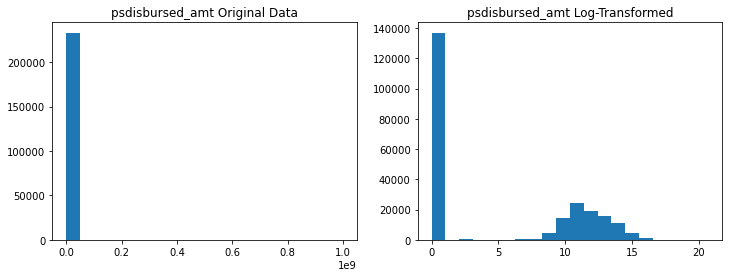

<Figure size 720x1440 with 0 Axes>

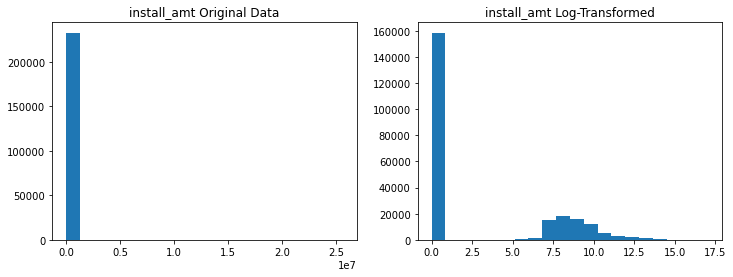

<Figure size 720x1440 with 0 Axes>

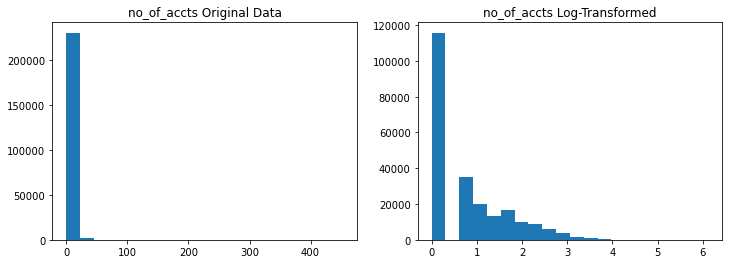

<Figure size 720x1440 with 0 Axes>

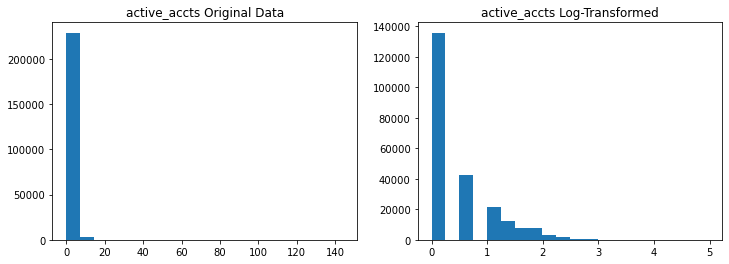

<Figure size 720x1440 with 0 Axes>

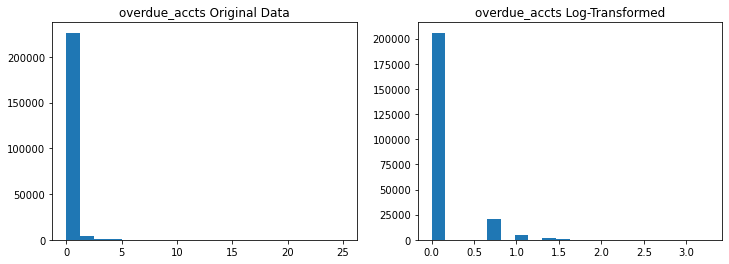

<Figure size 720x1440 with 0 Axes>

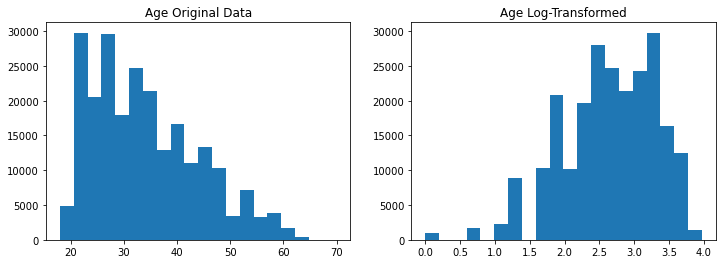

<Figure size 720x1440 with 0 Axes>

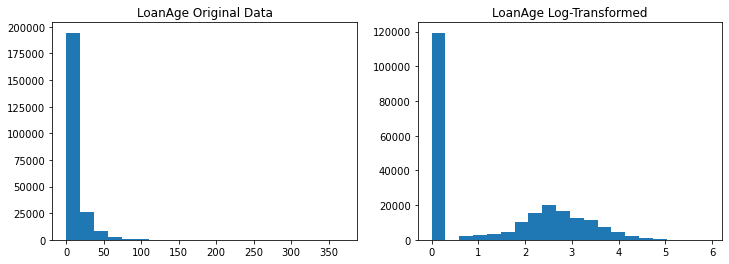

<Figure size 720x1440 with 0 Axes>

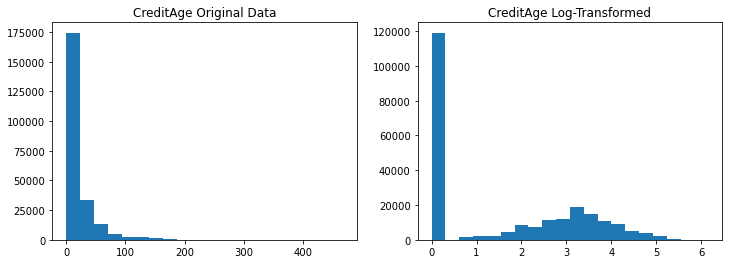

<Figure size 720x1440 with 0 Axes>

In [145]:
#log transform

#'current_balance','sanctioned_amt','psdisbursed_amt','install_amt'
for col in ['current_balance','psdisbursed_amt','install_amt','no_of_accts','active_accts','overdue_accts','Age','LoanAge','CreditAge']:
    logcol = col+'_log'
    df[logcol] = np.log(df[col]+1-min(df[col]))
    
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
    plt.figure(figsize=(10,20))
    #create histograms
    axs[0].hist(df[col], bins = 20)
    axs[1].hist(df[logcol],bins = 20)

    axs[0].set_title(col+' Original Data')
    axs[1].set_title(col+' Log-Transformed')

In [64]:
df = df.drop(columns=['UniqueID','branch_id','supplier_id','Employee_code_ID','Current_pincode_ID','Date.of.Birth','DisbursalDate','MobileNo_Avl_Flag','Aadhar_flag','asset_cost'])

In [65]:
df.columns

Index(['disbursed_amount', 'ltv', 'manufacturer_id', 'State_ID', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'CreditAge', 'LoanAge', 'Age',
       'no_of_accts', 'active_accts', 'overdue_accts', 'current_balance', 'psdisbursed_amt', 'install_amt', 'state_rate', 'Employment.Type_Salaried', 'Employment.Type_Self employed',
       'Employment.Type_missing', 'manufacturer_120', 'manufacturer_45', 'manufacturer_48', 'manufacturer_49', 'manufacturer_51', 'manufacturer_86', 'manufacturer_other', 'current_balance_log',
       'psdisbursed_amt_log', 'install_amt_log', 'no_of_accts_log', 'active_accts_log', 'overdue_accts_log', 'Age_log', 'LoanAge_log', 'CreditAge_log'],
      dtype='object')

In [74]:
features = ['disbursed_amount','ltv','PAN_flag','VoterID_flag','Driving_flag',
             'Passport_flag','PERFORM_CNS.SCORE','Employment.Type_Salaried','Employment.Type_Self employed',
             'Employment.Type_missing','manufacturer_120','manufacturer_45','manufacturer_48','manufacturer_49',
             'manufacturer_51','manufacturer_86','manufacturer_other','NEW.ACCTS.IN.LAST.SIX.MONTHS',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES','current_balance_log',  'psdisbursed_amt_log', 'no_of_accts_log', 'active_accts_log',
             'overdue_accts_log', 'Age_log','install_amt_log',
       'LoanAge_log', 'state_rate']





In [81]:
#
X = df[features]
y = df['loan_default']
# Scaling

sc = StandardScaler()
Xscaled = sc.fit_transform(X)
Xscaled = pd.DataFrame(Xscaled,columns=X.columns)


X_train, X_validate, y_train, y_validate = train_test_split(Xscaled, y, test_size=0.20, random_state=42)
logreg = LogisticRegression()
fit=logreg.fit(X_train, y_train)

In [169]:
Xscaled.head()

,disbursed_amount,asset_cost,ltv,employment_type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,manufacturer_encode,cns_score_group,state_rate,current_balance_log,sanctioned_amt_log,psdisbursed_amt_log,no_of_accts_log,active_accts_log,overdue_accts_log,Age_log,LoanAge_log,CreditAge_log
0,-0.291335,-0.921895,1.292133,1.156504,0.435916,-0.285929,-0.411719,-0.154257,-0.046172,-0.855453,-0.399782,-0.253566,-0.292450,-0.042587,-0.671245,-0.331925,-0.242354,-0.823223,-0.821780,-0.823042,-0.738155,-0.343411,0.292861,-0.901376,-0.902166
1,-0.555997,-0.544482,-0.132372,-0.894555,0.435916,-0.285929,-0.411719,-0.154257,-0.046172,0.911822,-0.399782,2.347632,-0.292450,-0.042587,1.421822,-0.331925,-0.194627,1.013598,1.018413,-0.052378,0.345503,2.113430,0.203357,1.312065,0.972012
2,-0.083183,-0.765651,1.299116,-0.894555,0.435916,-0.285929,-0.411719,-0.154257,-0.046172,-0.855453,-0.399782,-0.253566,-0.292450,-0.042587,-0.671245,-0.331925,-0.242354,-0.823223,-0.821780,-0.823042,-0.738155,-0.343411,0.108075,-0.901376,-0.902166
3,0.243307,-0.514764,1.198738,-0.894555,0.435916,-0.285929,-0.411719,-0.154257,-0.046172,0.045917,-0.399782,-0.253566,1.122986,-0.042587,2.119510,-0.331925,-0.242354,-0.823223,-0.821780,0.718287,-0.738155,-0.343411,-1.017120,0.628940,0.732899
4,-0.152567,-0.821604,1.190882,-0.894555,0.435916,-0.285929,-0.411719,-0.154257,-0.046172,-0.855453,-0.399782,-0.253566,1.122986,-0.042587,-0.671245,-0.331925,-0.242354,-0.823223,-0.821780,-0.823042,-0.738155,-0.343411,0.739137,-0.901376,-0.902166


In [78]:
Xscaled.mean()

disbursed_amount                       1.710774e-15
ltv                                   -2.722624e-15
PAN_flag                              -3.276022e-14
VoterID_flag                          -1.665489e-13
Driving_flag                           5.677082e-14
Passport_flag                          1.315724e-14
PERFORM_CNS.SCORE                      5.314064e-15
Employment.Type_Salaried               1.246884e-14
Employment.Type_Self employed          8.925338e-14
Employment.Type_missing               -4.270531e-14
manufacturer_120                      -1.020131e-13
manufacturer_45                       -6.691611e-14
manufacturer_48                       -1.122933e-13
manufacturer_49                        3.412579e-15
manufacturer_51                       -4.812998e-14
manufacturer_86                       -6.526918e-15
manufacturer_other                     8.594740e-14
NEW.ACCTS.IN.LAST.SIX.MONTHS          -1.425660e-14
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    2.621306e-14
NO.OF_INQUIR

[[36408 10096]
 [   69    58]]
The train AUC score is: 0.6385664735986767
The test AUC score is: 0.6340405403252073
The test F1 score is: 0.011282949129462115
The test accuracy is: 0.7820119662885205
The average precision is: 0.31276475799646947


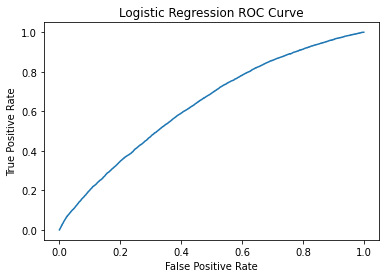

In [76]:
y_pred= logreg.predict(X_validate)

print(confusion_matrix(y_pred,y_validate))

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_validate)
y_train_prob = logreg.predict_proba(X_train)
y_test_prob = logreg.predict_proba(X_validate)

print('The train AUC score is:',roc_auc_score(y_train,y_train_prob[:,1]))
print('The test AUC score is:',roc_auc_score(y_validate,y_test_prob[:,1]))

print('The test F1 score is:',f1_score(y_validate,y_pred))
print('The test accuracy is:',accuracy_score(y_validate, y_pred))
print('The average precision is:',average_precision_score(y_validate,y_test_prob[:,1]))

y_pred_prob = logreg.predict_proba(X_validate)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()



In [82]:
#print(fit_sm.coef_, fit_sm.intercept_)

df_f = pd.DataFrame(zip(X_train.columns, np.transpose(fit.coef_)), columns=['features', 'coef']) 

df_f.sort_values(by="coef",ascending=False)

,features,coef
1,ltv,[0.3208442917633184]
27,state_rate,[0.20079333176460998]
23,overdue_accts_log,[0.15041563533525418]
21,psdisbursed_amt_log,[0.13245607618017502]
19,NO.OF_INQUIRIES,[0.09970004691962366]
18,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,[0.08907720982734602]
0,disbursed_amount,[0.07953211971979153]
12,manufacturer_48,[0.07927647272207151]
8,Employment.Type_Self employed,[0.06253269065776115]
25,install_amt_log,[0.0523313370465585]


### smote

In [83]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)
X_train_sm.shape, y_train_sm.shape

((292132, 28), (292132,))

In [84]:
logreg_sm = LogisticRegression()
fit_sm=logreg_sm.fit(X_train_sm, y_train_sm)



In [88]:
print(y_validate.shape)
print(y_validate.sum())

(46631,)
10154


[[20489  3763]
 [15988  6391]]
The train AUC score is: 0.638243388931479
The test AUC score is: 0.6344513614713163
The test F1 score is: 0.3928933698091169
The test accuracy is: 0.5764405652891853
The average precision is: 0.3132900739024862


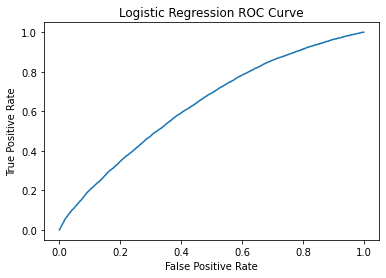

In [86]:
y_pred= logreg_sm.predict(X_validate)

print(confusion_matrix(y_pred,y_validate))

y_train_pred = logreg_sm.predict(X_train)
y_test_pred = logreg_sm.predict(X_validate)
y_train_prob = logreg_sm.predict_proba(X_train)
y_test_prob = logreg_sm.predict_proba(X_validate)

print('The train AUC score is:',roc_auc_score(y_train,y_train_prob[:,1]))
print('The test AUC score is:',roc_auc_score(y_validate,y_test_prob[:,1]))

print('The test F1 score is:',f1_score(y_validate,y_pred))
print('The test accuracy is:',accuracy_score(y_validate, y_pred))
print('The average precision is:',average_precision_score(y_validate,y_test_prob[:,1]))


fpr, tpr, thresholds = roc_curve(y_validate, y_test_prob[:,1])
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


In [85]:
#print(fit_sm.coef_, fit_sm.intercept_)

df_f = pd.DataFrame(zip(X_train.columns, np.transpose(fit_sm.coef_)), columns=['features', 'coef']) 

df_f.sort_values(by="coef",ascending=False)

,features,coef
1,ltv,[0.35995151467055225]
27,state_rate,[0.21067403059453937]
21,psdisbursed_amt_log,[0.17083525109207112]
23,overdue_accts_log,[0.16195616233873383]
19,NO.OF_INQUIRIES,[0.09689909422629787]
18,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,[0.09595112960649425]
12,manufacturer_48,[0.0856815045470075]
0,disbursed_amount,[0.07698178708393859]
8,Employment.Type_Self employed,[0.06895309467025604]
25,install_amt_log,[0.06538390548467024]


### XGBoost

In [111]:
X_train, X_validate, y_train, y_validate = train_test_split(Xscaled, y, test_size=0.20, random_state=42)

smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)
X_train_sm.shape, y_train_sm.shape

((292132, 28), (292132,))

In [114]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=300,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 objective= 'binary:logistic',
 seed=42)
xgb1.fit(X_train, y_train)

/Users/kononami/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:02:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [126]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 #colsample_bytree=0.8,
 objective= 'binary:logistic',
 #scale_pos_weight=1,
 seed=42)
xgb2.fit(X_train_sm, y_train_sm)

/Users/kononami/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:11:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [128]:
xgb3 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 #colsample_bytree=0.8,
 objective= 'binary:logistic',
 #scale_pos_weight=1,
 seed=42)
xgb3.fit(X_train_sm, y_train_sm)

/Users/kononami/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:16:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [129]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=200,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 #colsample_bytree=0.8,
 objective= 'binary:logistic',
 #scale_pos_weight=1,
 seed=42)
xgb4.fit(X_train_sm, y_train_sm)

[08:16:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [130]:
xgb5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 #colsample_bytree=0.8,
 objective= 'binary:logistic',
 #scale_pos_weight=1,
 seed=42)
xgb5.fit(X_train_sm, y_train_sm)

[08:17:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [131]:
xgb6 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=100,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 #colsample_bytree=0.8,
 objective= 'binary:logistic',
 #scale_pos_weight=1,
 seed=42)
xgb6.fit(X_train_sm, y_train_sm)

[08:17:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [132]:
xgb7 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=100,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 #colsample_bytree=0.8,
 objective= 'binary:logistic',
 #scale_pos_weight=1,
 seed=42)
xgb7.fit(X_train_sm, y_train_sm)

[08:17:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[36305  9972]
 [  172   182]]
The train AUC score is: 0.7265026091189377
The test AUC score is: 0.6509811341938041
The test F1 score is: 0.034640274076893796
The test accuracy is: 0.7824623104801527
The average precision is: 0.32841763381152256


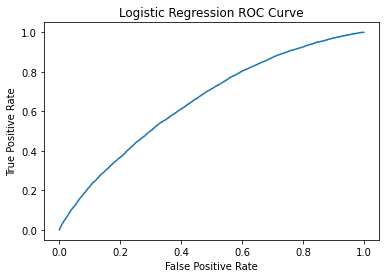

In [115]:
model = xgb1
y_pred= model.predict(X_validate)

print(confusion_matrix(y_pred,y_validate))

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_validate)
y_train_prob = model.predict_proba(X_train)
y_test_prob = model.predict_proba(X_validate)

print('The train AUC score is:',roc_auc_score(y_train,y_train_prob[:,1]))
print('The test AUC score is:',roc_auc_score(y_validate,y_test_prob[:,1]))

print('The test F1 score is:',f1_score(y_validate,y_pred))
print('The test accuracy is:',accuracy_score(y_validate, y_pred))
print('The average precision is:',average_precision_score(y_validate,y_test_prob[:,1]))


fpr, tpr, thresholds = roc_curve(y_validate, y_test_prob[:,1])
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


[[33778  8781]
 [ 2699  1373]]
The train AUC score is: 0.6427730012445907
The test AUC score is: 0.6287539142321606
The test F1 score is: 0.1930268522423731
The test accuracy is: 0.7538118419077438
The average precision is: 0.3016521665074709


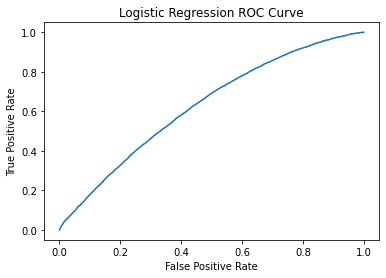

In [127]:
model = xgb2
y_pred= model.predict(X_validate)

print(confusion_matrix(y_pred,y_validate))

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_validate)
y_train_prob = model.predict_proba(X_train)
y_test_prob = model.predict_proba(X_validate)


print(roc_auc_score(y_train,y_train_prob[:,1]))
print(roc_auc_score(y_validate,y_test_prob[:,1]))

print(f1_score(y_validate,y_pred))
print(accuracy_score(y_validate, y_pred))
print(average_precision_score(y_validate,y_test_prob[:,1]))


In [144]:
for model in [xgb2,xgb3,xgb4,xgb5,xgb6,xgb7]:
    
    y_pred= model.predict(X_validate)

    print(confusion_matrix(y_pred,y_validate))
    cm = confusion_matrix(y_pred,y_validate)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_validate)
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_validate)

   
    print(roc_auc_score(y_train,y_train_prob[:,1]))
    print(roc_auc_score(y_validate,y_test_prob[:,1]))
    print(cm[1,1]/(cm[1,1]+cm[0,1]))
    print(f1_score(y_validate,y_pred))
    print(accuracy_score(y_validate, y_pred))
    print(average_precision_score(y_validate,y_test_prob[:,1]))

[[33778  8781]
 [ 2699  1373]]
0.6427730012445907
0.6287539142321606
0.13521764821745125
0.1930268522423731
0.7538118419077438
0.3016521665074709
[[31174  7654]
 [ 5303  2500]]
0.6351684423038296
0.6251936937886271
0.24620839078195786
0.2784429470401515
0.7221376337629474
0.298776377556121
[[24155  5204]
 [12322  4950]]
0.6263480324256063
0.6174544846494237
0.4874926137482765
0.36097134106322476
0.6241556046406896
0.29105407429437224
[[30776  7519]
 [ 5701  2635]]
0.6350415514190408
0.624157379000668
0.25950364388418357
0.28501892915089233
0.716497608886792
0.2969365429444643
[[27094  6163]
 [ 9383  3991]]
0.6317656663585631
0.6219782838867076
0.3930470750443175
0.33925535532131923
0.666616628423152
0.2975615588105115
[[23780  5258]
 [12697  4896]]
0.6211213590803148
0.612009775449794
0.48217451250738624
0.35290301654232886
0.6149557161544895
0.2858444160629744


In [140]:
df_f=pd.DataFrame()
df_f["Features"]=X_train.columns.to_list()

df_f["Importance"]=xgb4.feature_importances_



print(df_f.sort_values(by="Importance",ascending=False))

                               Features  Importance
27                           state_rate    0.155255
0                      disbursed_amount    0.106875
17         NEW.ACCTS.IN.LAST.SIX.MONTHS    0.098865
22                     active_accts_log    0.090112
21                  psdisbursed_amt_log    0.075055
1                                   ltv    0.069572
15                      manufacturer_86    0.058132
12                      manufacturer_48    0.057080
6                     PERFORM_CNS.SCORE    0.053130
19                      NO.OF_INQUIRIES    0.043519
7              Employment.Type_Salaried    0.041875
24                              Age_log    0.038571
23                    overdue_accts_log    0.029815
8         Employment.Type_Self employed    0.023951
20                  current_balance_log    0.013902
25                      install_amt_log    0.013869
18  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.009863
14                      manufacturer_51    0.007684
26          